In [1]:
import os
import sys
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt

import time
import datetime
import argparse
import numpy as np
import pandas as pd
import xarray as xr

from random import SystemRandom
import logging
import copy

import torch
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from rich.progress import track
import tqdm
import re

adjoint=True
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

from sunpy.visualization import colormaps as cm    

import torchvision
import torchvision.transforms as T

import node_utils as nut
import data_utils as dut

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)

Copying over args from notebook 11, ignore the irrelevant ones.

In [4]:
args = {
    "niters": 2500,
    "lr": 1e-2,
    "save": "experiments/",
    "load": None,
    "r": 1991,
    "node-layers": 2,
    "mlp-layers": 1,
    "latents": 8,  # 68818 has 8 latent dims
    # "latents": 20, # 44467 expt ID, else only 8 dims
    "units": 50,
    # "test_mode": "t5p4",
    "test_mode": "t12v4p7",
    "resize_dims": (32, 128),
    "param_scaling": [1, 1],
    "warm_start": 41574,
    "do_warm_start": False,
    "quadratic": False,
    "loss": "smooth_l1",
    "l2int": 0.1, # "int_t ||f||_2"
    "JFrobint": 0.1, # "int_t ||df/dx||_F",
    "batch_size": 4
    # "loss": "mae"
    # "test_mode" can take values "t2p1, t4p1" for now (number of training vs val and test sims)
}

args

{'niters': 2500,
 'lr': 0.01,
 'save': 'experiments/',
 'load': None,
 'r': 1991,
 'node-layers': 2,
 'mlp-layers': 1,
 'latents': 8,
 'units': 50,
 'test_mode': 't12v4p7',
 'resize_dims': (32, 128),
 'param_scaling': [1, 1],
 'warm_start': 41574,
 'do_warm_start': False,
 'quadratic': False,
 'loss': 'smooth_l1',
 'l2int': 0.1,
 'JFrobint': 0.1,
 'batch_size': 4}

In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [6]:
validation_dir = "./validation_data"
validation_file = os.path.join(validation_dir, "CR2161_validation_PolarTensor.npy")
sim_file = os.path.join(validation_dir, "CR2161_SimID4edge_validation.npy")
param_file = os.path.join(validation_dir, "params_2161_validation.txt")

In [7]:
all_sim_ids = np.linspace(1, 24, 24, dtype=int)

data = np.load(validation_file)
files = np.load(sim_file)
params = np.loadtxt(param_file)

successful_sims = np.array([int(re.search(r'\d+', f).group()) for f in files])

train_idx = np.array([10, 21])
# Load and scale params

train_params_raw = params[successful_sims[train_idx] - 1, :]/args["param_scaling"]

train_params_raw


all_timesteps = np.linspace(2, 180, 90, dtype=int)
tMinIdx = 46 # hardcoding for now, change later to accomodate variable length sequences
tMaxIdx = len(all_timesteps) - 1
nTimesteps = tMaxIdx - tMinIdx + 1

# scale time appropriately
tt = np.linspace(0, 1, tMaxIdx - tMinIdx + 1)
tpredict = torch.Tensor(tt).to(device)

# remove last 2 rows in vertical dimension as they also captured the edge of the end of the FOV (zero valued pixels)
train_data_raw = data[:126, :, :, train_idx]

# resize raw data to 32x128 tensors and transpose so that the order is (n, t, x, y)
resize_dims = args["resize_dims"]
input_dim = resize_dims[0] * resize_dims[1]

train_data = T.Resize(size=resize_dims,
                              antialias=True
                              )(torch.Tensor(train_data_raw.transpose(3, 2, 0, 1)))

# calculate max of train data to scale all data
max_train = torch.max(train_data)
min_train = torch.min(train_data)

In [8]:
print(train_params_raw)

[[19.166 -1.   ]
 [19.166  1.   ]]


In [9]:
train_data.shape

torch.Size([2, 90, 32, 128])

In [10]:
# np.save("/home/ajivani/train_data_2dwl.npy", train_data)

In [11]:
BS_train = train_params_raw[:, 0] * args["param_scaling"][0]
iH_train = train_params_raw[:, 1] * args["param_scaling"][1]

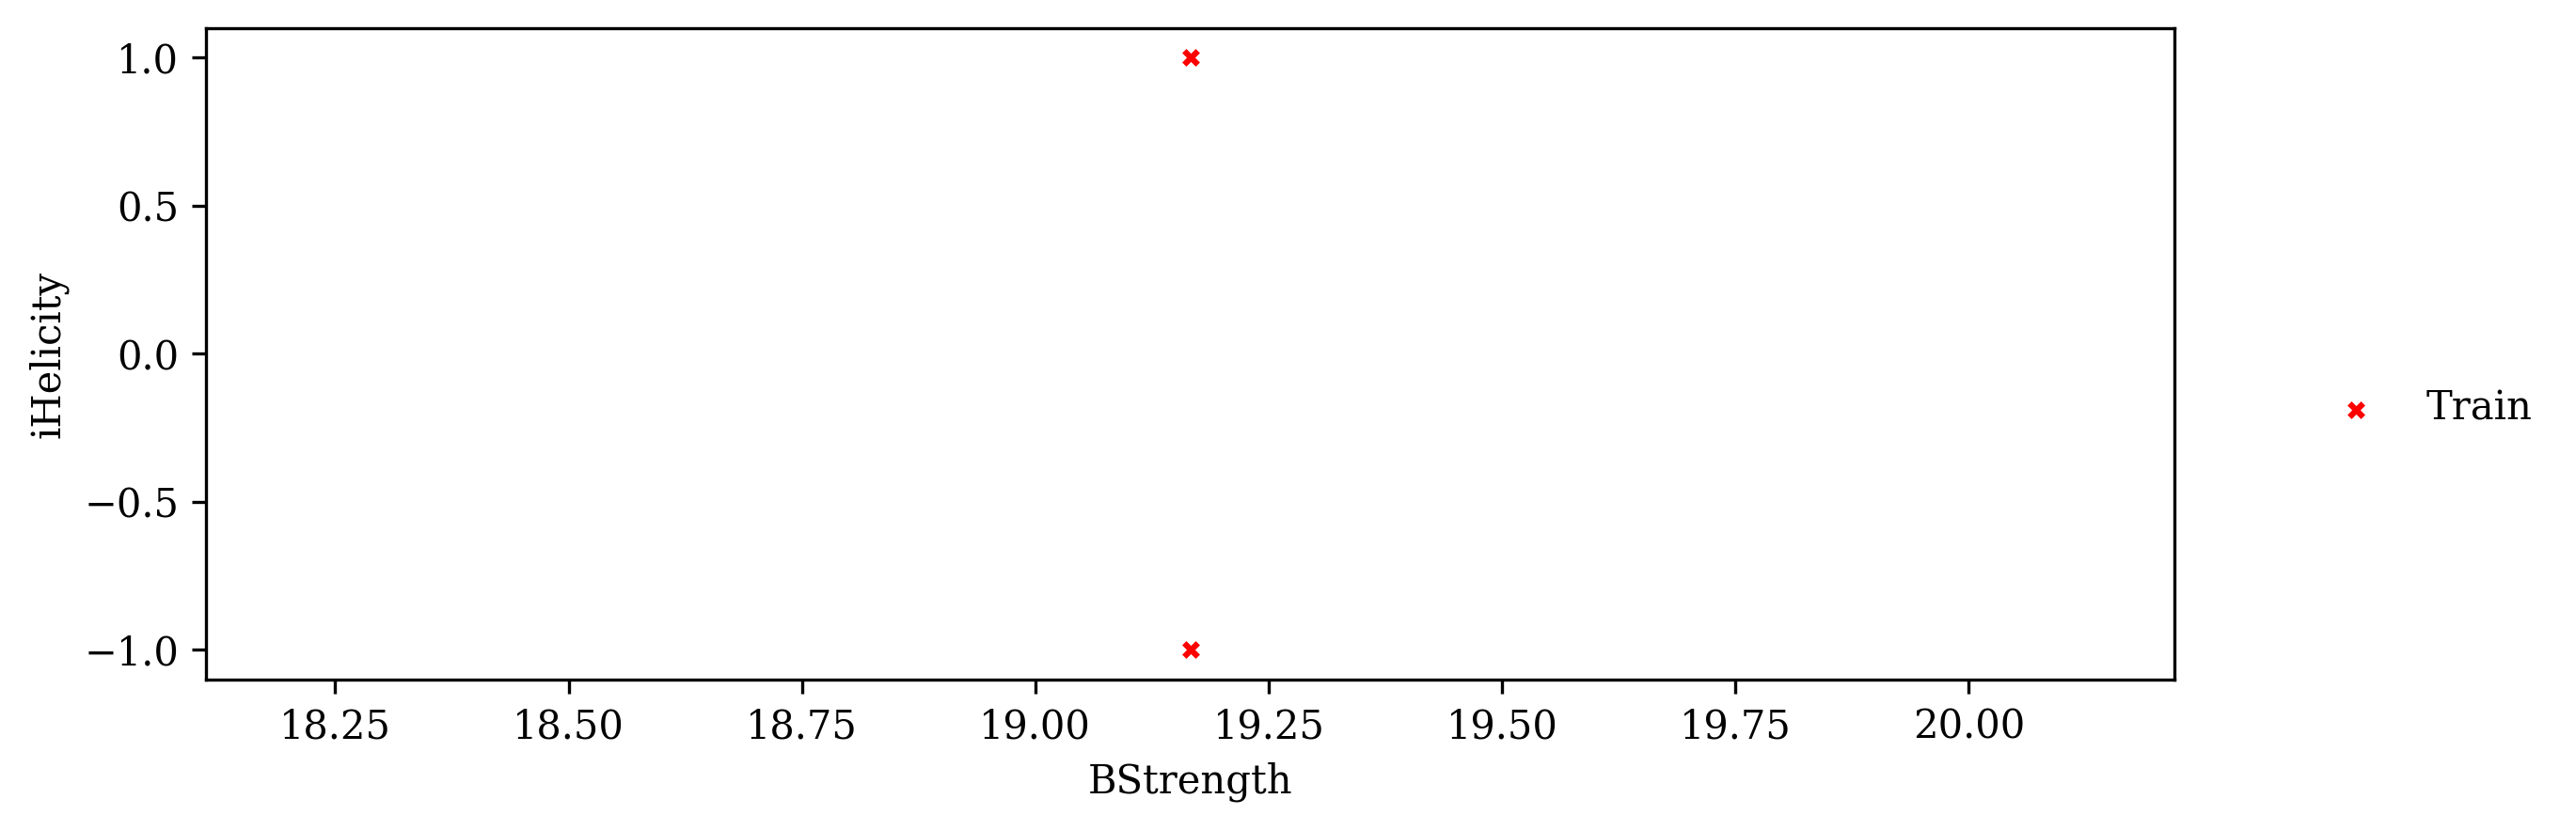

In [12]:
plt.scatter(BS_train, iH_train, s=12, c='red', marker='x', label="Train")
plt.xlabel("BStrength")
plt.ylabel("iHelicity")
plt.legend(bbox_to_anchor=(1.2, 0.5))

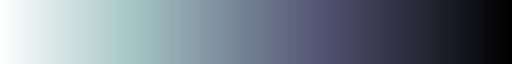

In [13]:
from sunpy.visualization import colormaps as cm

lc3_reg = cm.cmlist['soholasco3']
lc3_reg

lc3 = cm.cmlist['soholasco3'].reversed()
lc3

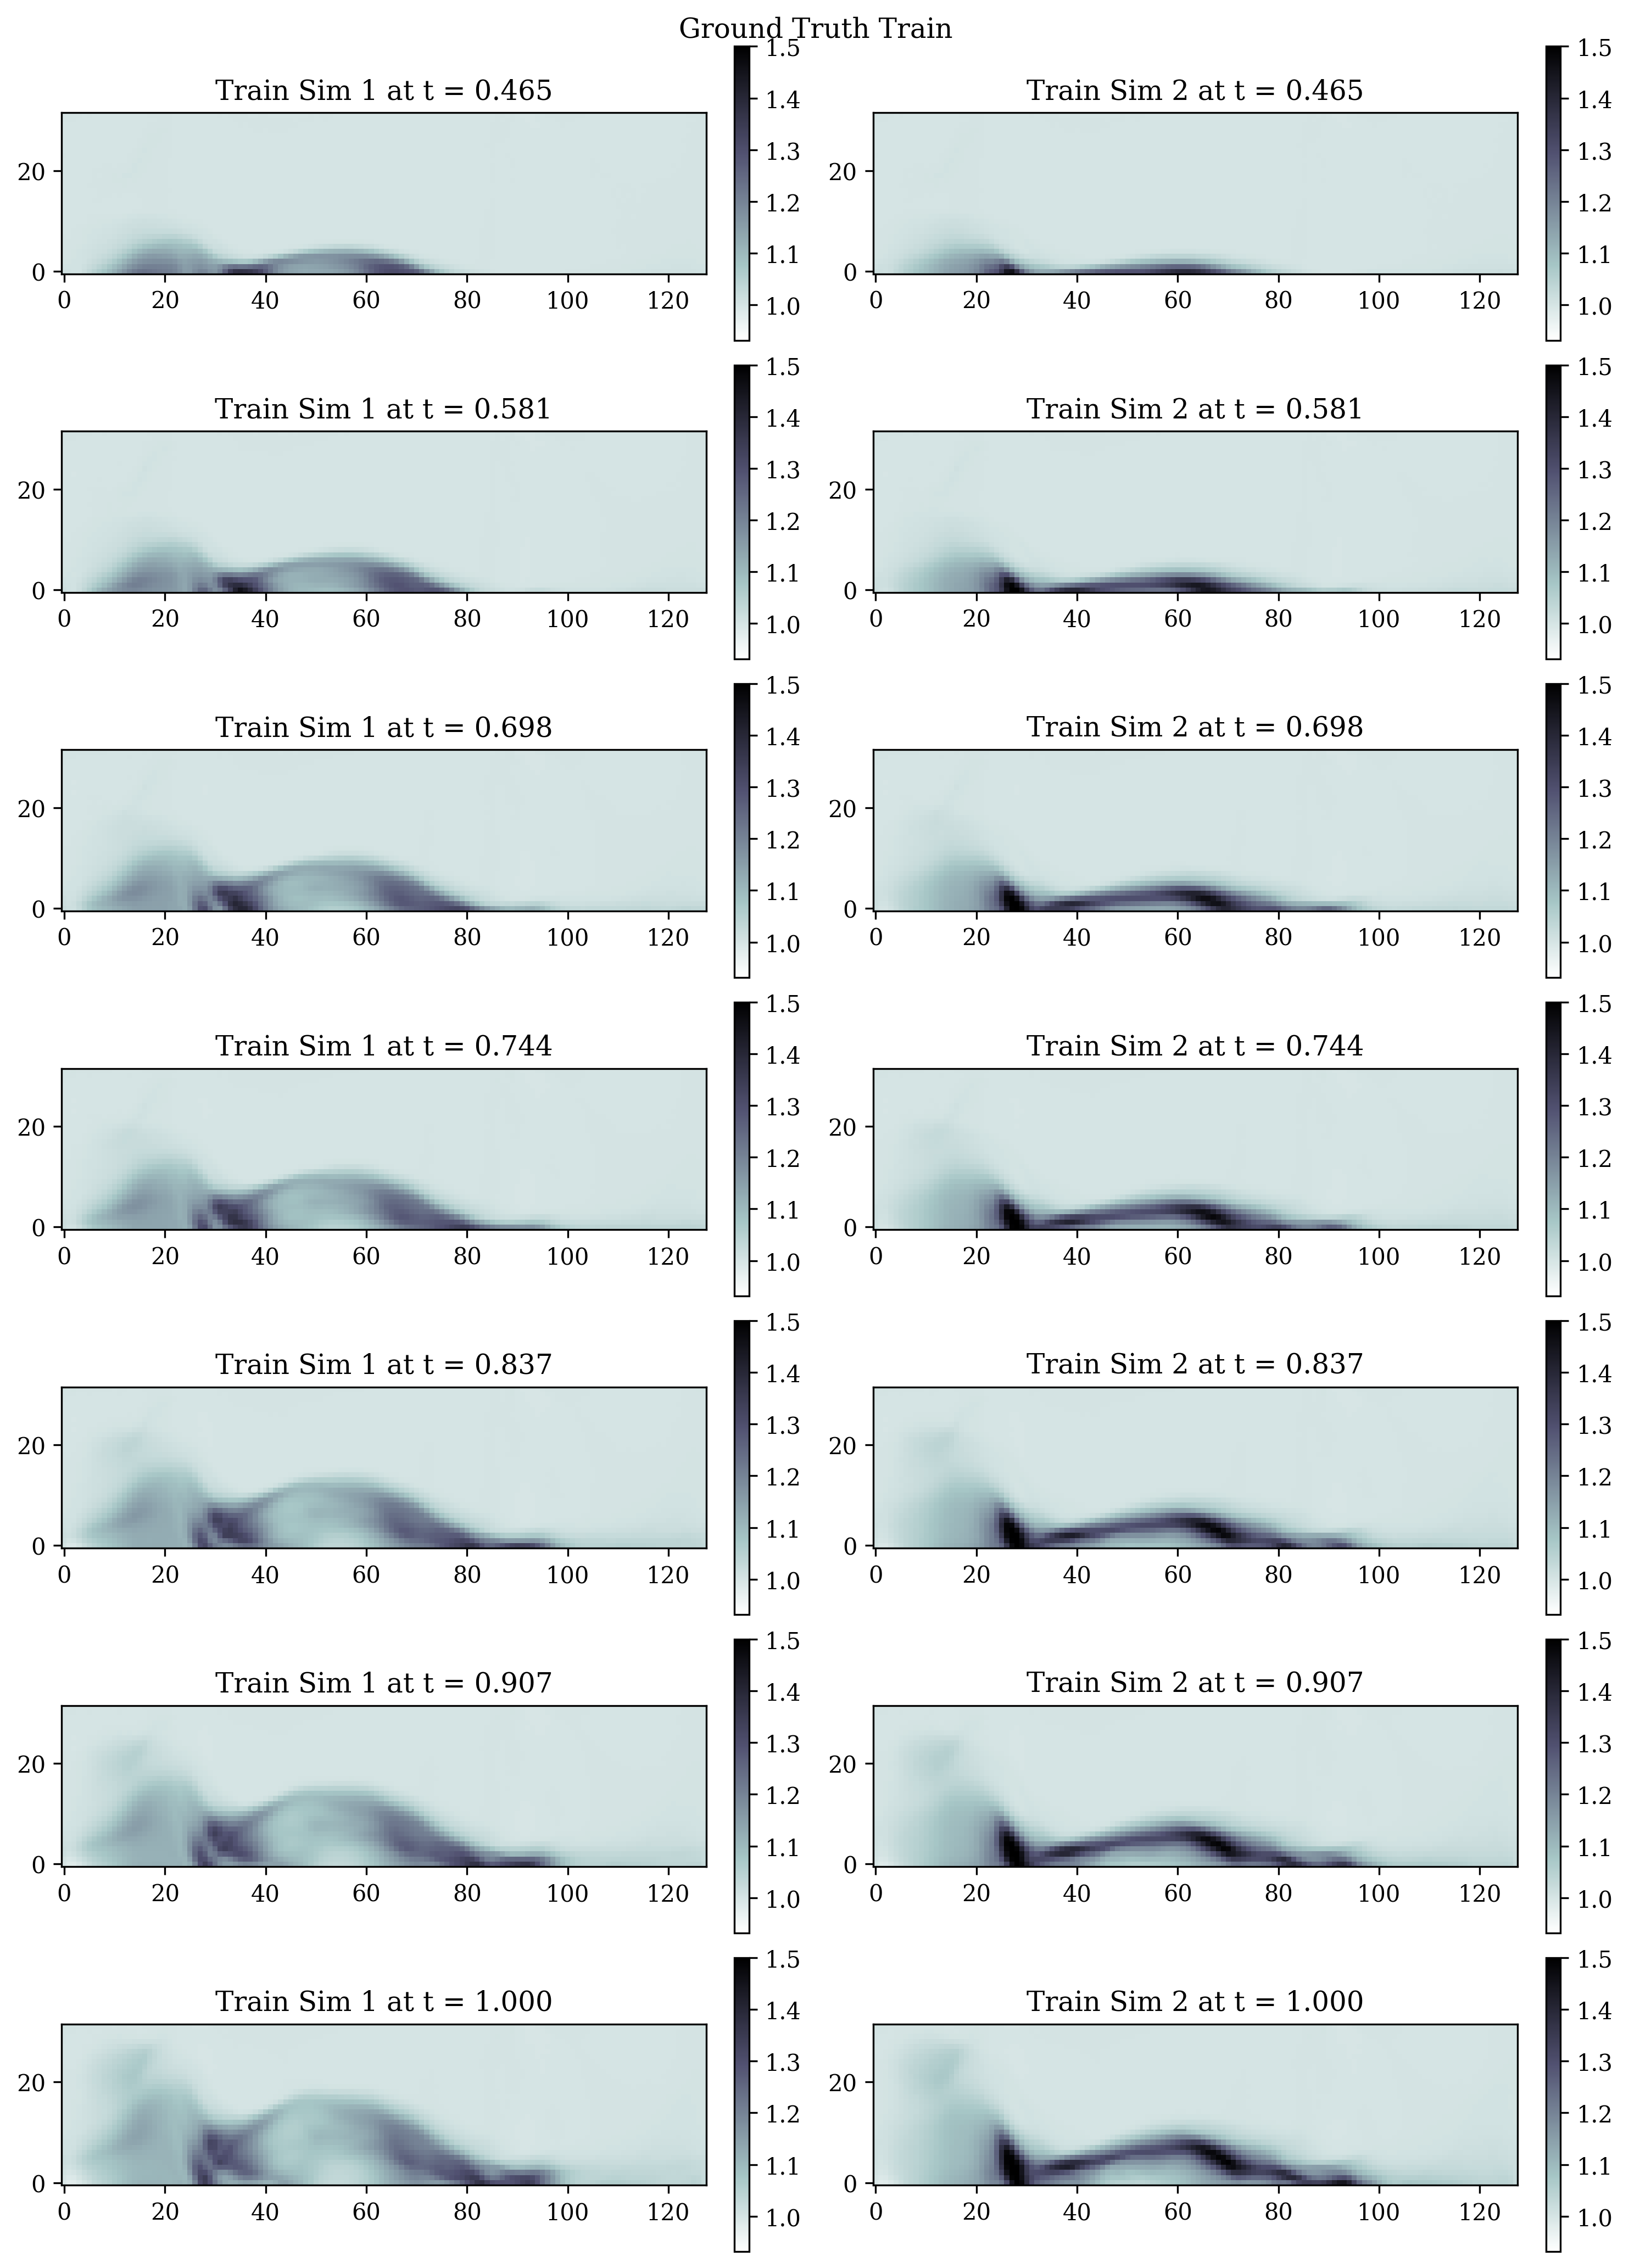

In [14]:
time_idx_to_plot = np.array([20, 25, 30, 32, 36, 39, 43])
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(train_data[0, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=min_train,
                           vmax=max_train
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Train Sim 1 at t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(train_data[1, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=min_train,
                           vmax=max_train
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Train Sim 2 at t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Ground Truth Train")
fig.tight_layout()

In [15]:
nx = 128
ny = 32
lx = 1.0
ly = 0.25

# Time parameters
# nt = 1000  # Number of time steps
# dt = 0.001  # Time step size
dx = lx / (nx - 1)
dy = ly / (ny - 1)

# x = np.linspace(0, lx, nx + 1)
# y = np.linspace(0, ly, ny + 1)

x = np.linspace(-31 * np.pi / 180, 82 * np.pi / 180, nx + 1)
y = np.linspace(4, 24, ny + 1)

X, Y = np.meshgrid(x, y)

xm = x[:-1] + (x[1] - x[0]) / 2  # x-Grid (location of cell centers)
ym = y[:-1] + (y[1] - y[0]) / 2  # y-Grid (location of cell centers)
XM, YM = np.meshgrid(xm, ym)  # Meshgrid for cell centers
dx = xm[1] - xm[0]  # Grid spacing in x
dy = ym[1] - ym[0]  # Grid spacing in y

In [16]:
ym.shape

(32,)

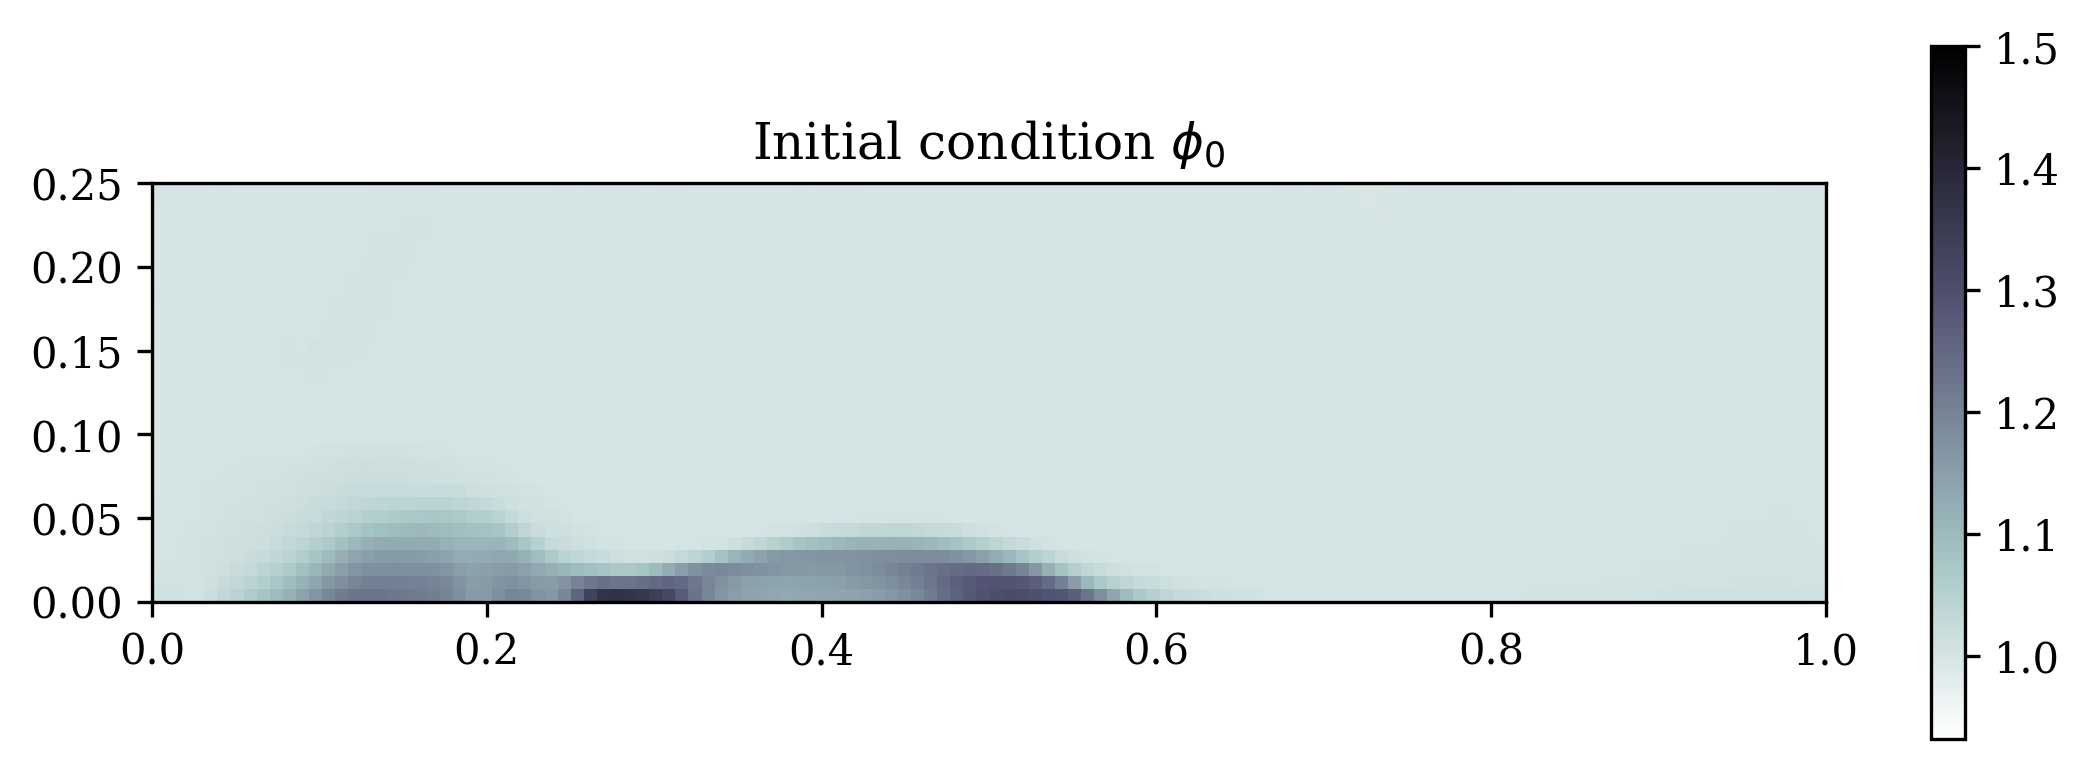

In [17]:
phi0 = copy.deepcopy(train_data[0, 20, :, :])
plt.imshow(phi0,
            origin="lower",
            cmap=lc3,
            vmin=min_train,
            vmax=max_train,
            extent=(0, 1, 0, 0.25)
#            extent=(-31 * np.pi / 180, 82 * np.pi / 180, 4, 24)
            )
plt.title(r"Initial condition $\phi_0$")
plt.colorbar()

In [18]:
import sys
sys.path.append(os.path.join('/home/ajivani/', 'data-driven-pdes'))

In [19]:
# import tensorflow as tf
# tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.enable_eager_execution()

In [20]:
import datadrivenpdes as pde
from datadrivenpdes.core import grids
from datadrivenpdes.core import integrate
from datadrivenpdes.core import models
from datadrivenpdes.core import tensor_ops
from datadrivenpdes.advection import equations as advection_equations
from datadrivenpdes.pipelines import model_utils

2024-05-22 10:05:33.143198: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# equation = pde.advection.equations.FiniteVolumeAdvectionDiffusion(diffusion_coefficient=0.01)

# NX=256
# NY=256 # 1D can be obtained by haveing a y dimension of size 1
# LX=2*np.pi

# gg = grids.Grid.from_period(size=256, length=2*np.pi)
# # gg = grids.Grid(size_x=256, size_y=256, step=2*np.pi/256)

# x, y = gg.get_mesh()

# initial_state = equation.random_state(gg, seed=7109179)

# time_step = equation.get_time_step(gg)
# times = time_step*np.arange(400)
# results = pde.core.integrate.integrate_times(
#     model=pde.core.models.FiniteDifferenceModel(equation, gg),
#     state=initial_state,
#     times=times, axis=0)

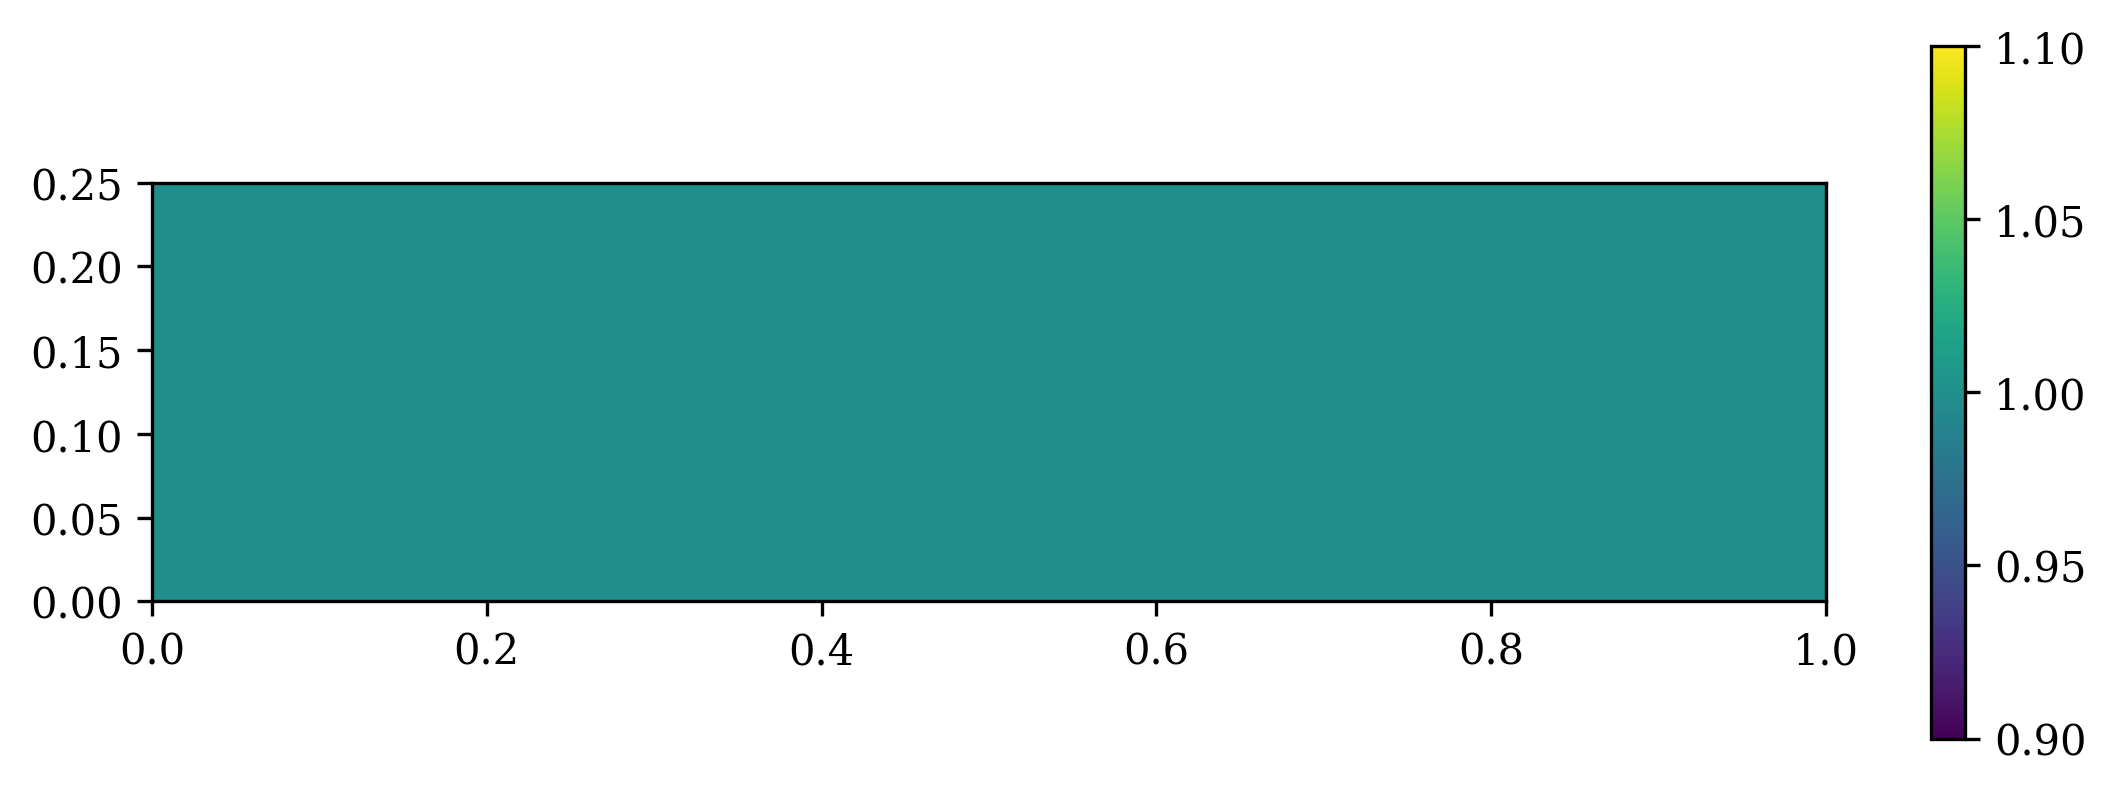

In [22]:
kf = 1.0
f_decay = np.ones((ny, nx))
# for i in range(ny):
#     for j in range(nx):
#         f_decay[i, j] = 1.0* pow(abs(ym[i]), 2)
        
plt.imshow(f_decay, 
           origin="lower",
           extent=[0, 1.0, 0, 0.25])
plt.colorbar()

In [23]:
k1 = 0.0 # ux
k2 = 0.6  # uy

u = np.zeros((ny, nx + 1))
v = np.zeros((ny + 1, nx))

for i in range(ny):
    for j in range(nx + 1):
        # u[i, j] = k1 * x[j]
        u[i, j] = k1 * (- abs(x[j] - 0.5))**2

for i in range(ny + 1):
    for j in range(nx):
        v[i, j] = k2 * pow(abs(y[i]), 1.2) + 1.0

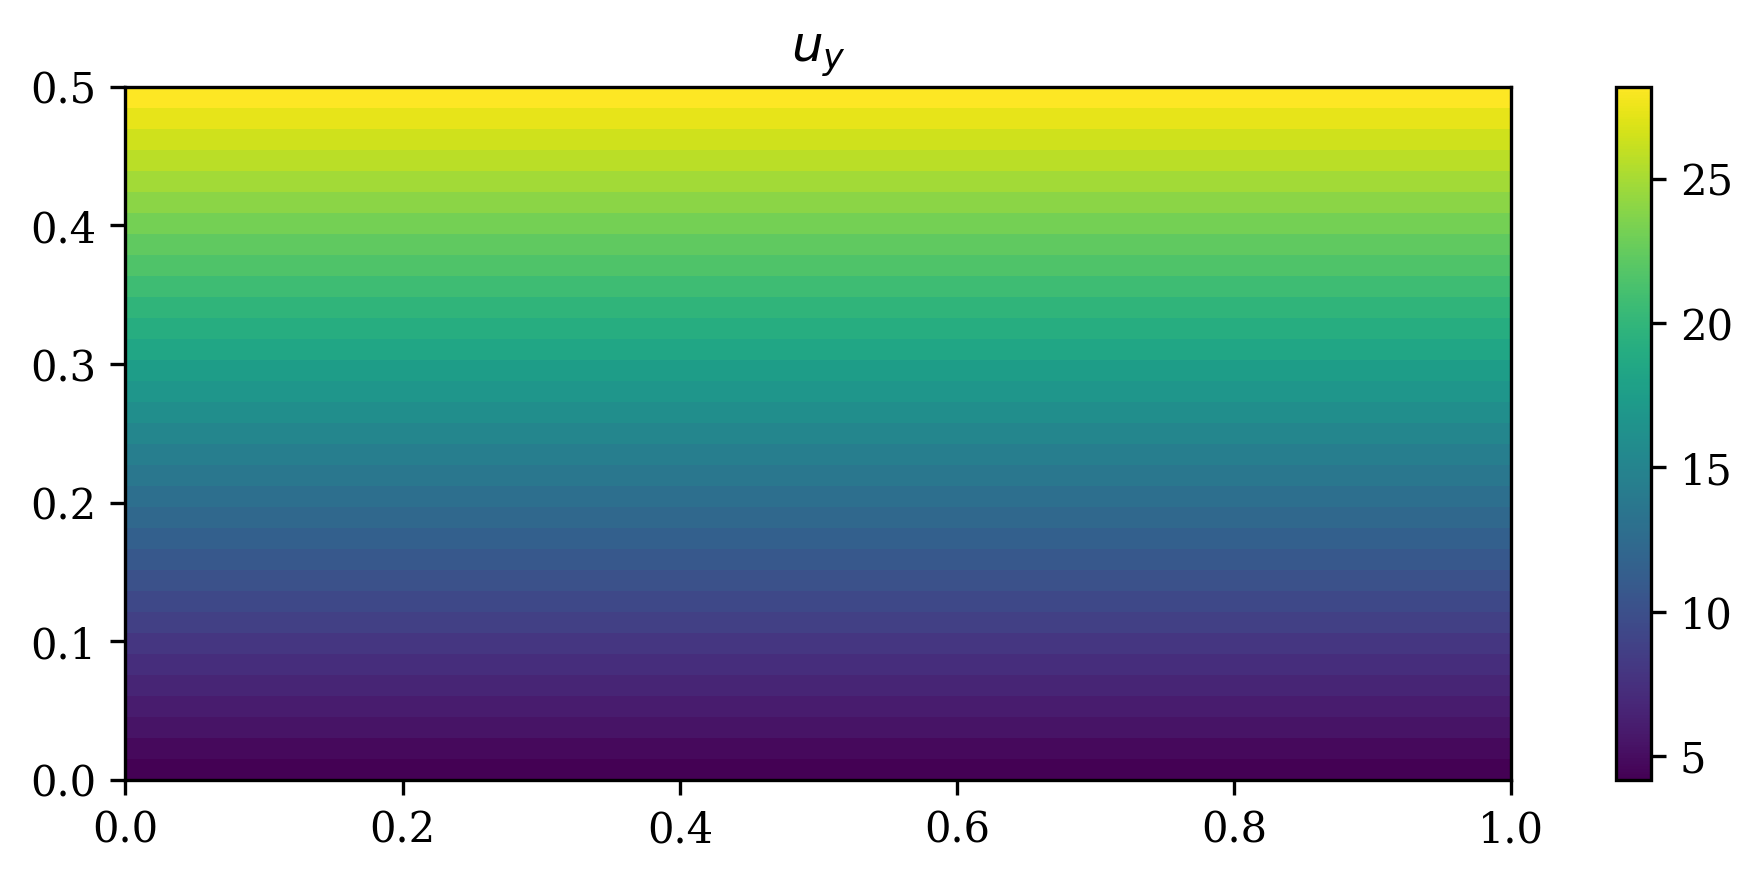

In [24]:
plt.imshow(v, 
           origin="lower",
           extent=[0, 1.0, 0, 0.5])
plt.title(r"$u_y$")
plt.colorbar()

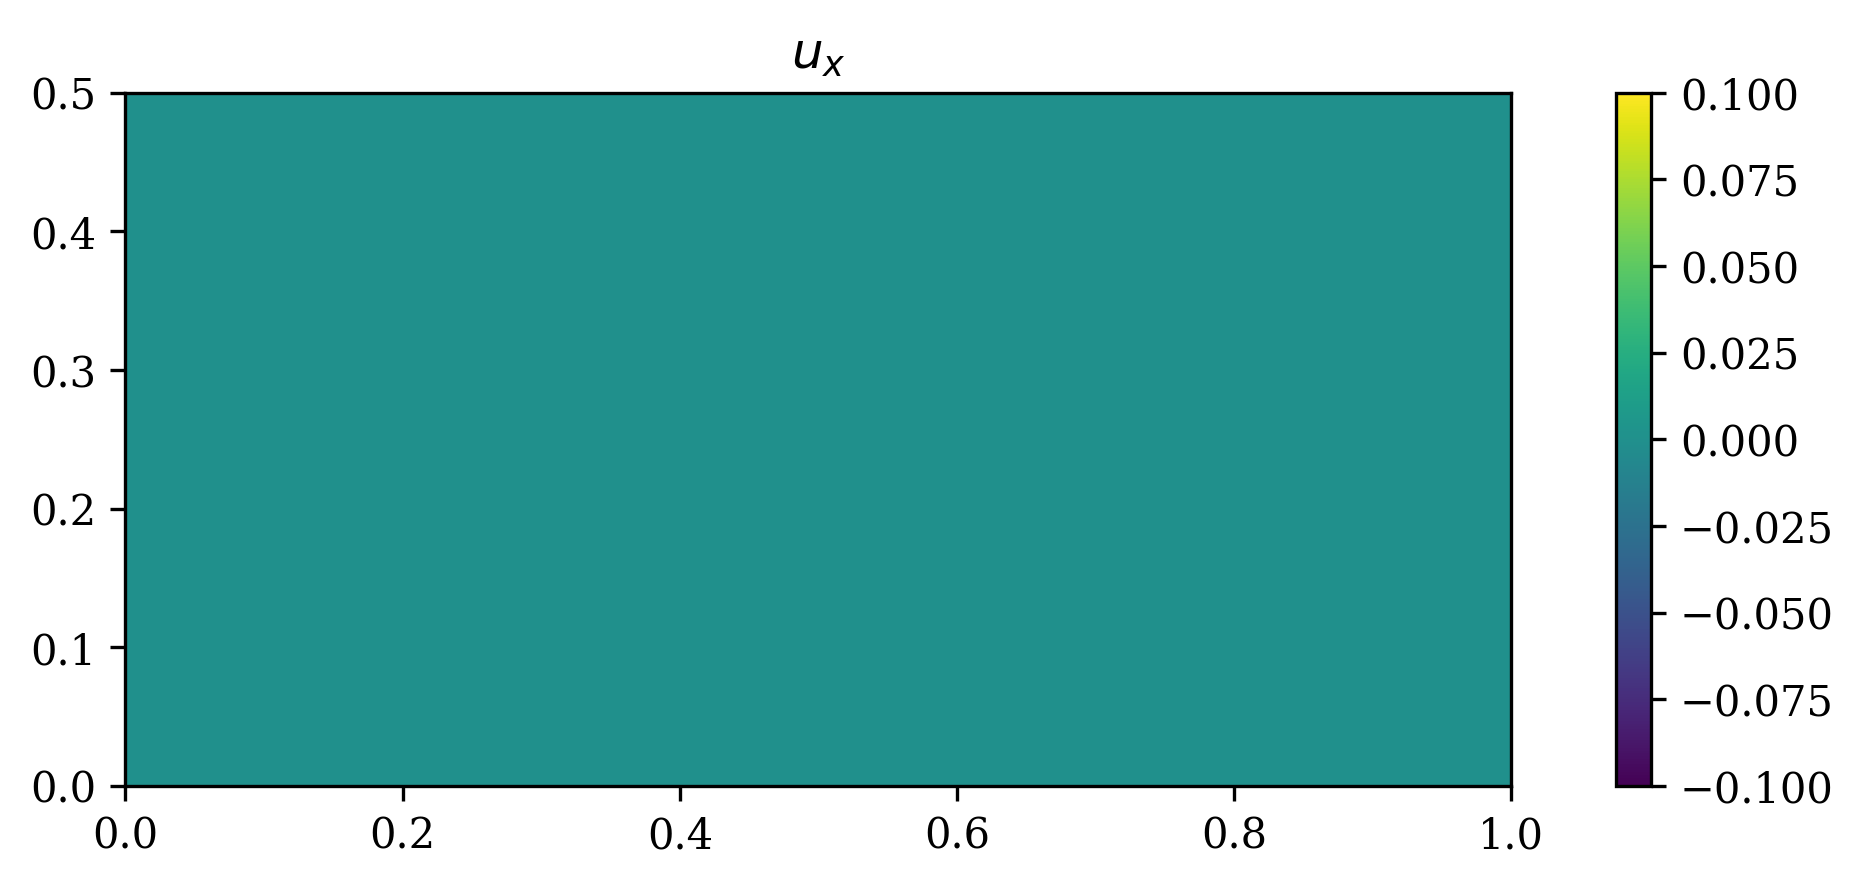

In [25]:
plt.imshow(u, 
           origin="lower",
           extent=[0, 1.0, 0, 0.5])
plt.title(r"$u_x$")
plt.colorbar()

In [26]:
cfl = 0.6
maxU = np.max(np.abs(u))
maxU = np.max([maxU, np.max(np.abs(v))])
dt = cfl * dx / maxU

# nt = int(1/dt)
nt = 400
print(dt, nt)

0.00032794901031219415 400


In [27]:
# Time loop
phi_til = np.zeros((ny, nx))
for n in track(range(nt), description="Processing timesteps..."):
    if n == 0:
      # phi_tilde_old = (phi0 * f_decay).copy()
      phi_tilde_old = copy.deepcopy(phi0 * f_decay)
    else:
      # phi_tilde_old = phi_til.copy()
      phi_tilde_old = copy.deepcopy(phi_til)

    for i in range(1, ny - 1):
        for j in range(1, nx - 1):
            phi_til[i, j] = (
                phi_tilde_old[i, j]
                - (dt / dx) * (u[i, j + 1] * phi_tilde_old[i, j] - u[i, j] * phi_tilde_old[i, j - 1])
                - (dt / dy) * (v[i + 1, j] * phi_tilde_old[i, j] - v[i, j] * phi_tilde_old[i - 1, j])
            )

    # # periodic
    # phi_til[:, 0] = phi_til[:, nx - 1]
    # phi_til[:, nx - 1] = phi_til[:, 0]

    # # neumann
    # phi_til[ny - 1, 1:(nx-1)] = phi_til[ny - 2, 1:(nx - 1)]
    # phi_til[0, 1:(nx - 1)] = phi_til[1, 1:(nx - 1)]

    # neumann everywhere
    phi_til[0, :] = phi_til[1, :]
    phi_til[ny - 1, :] = phi_til[ny - 2, :]
    phi_til[:, 0] = phi_til[:, 1]
    phi_til[:, nx - 1] = phi_til[:, nx - 2]

Processing timesteps... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:03

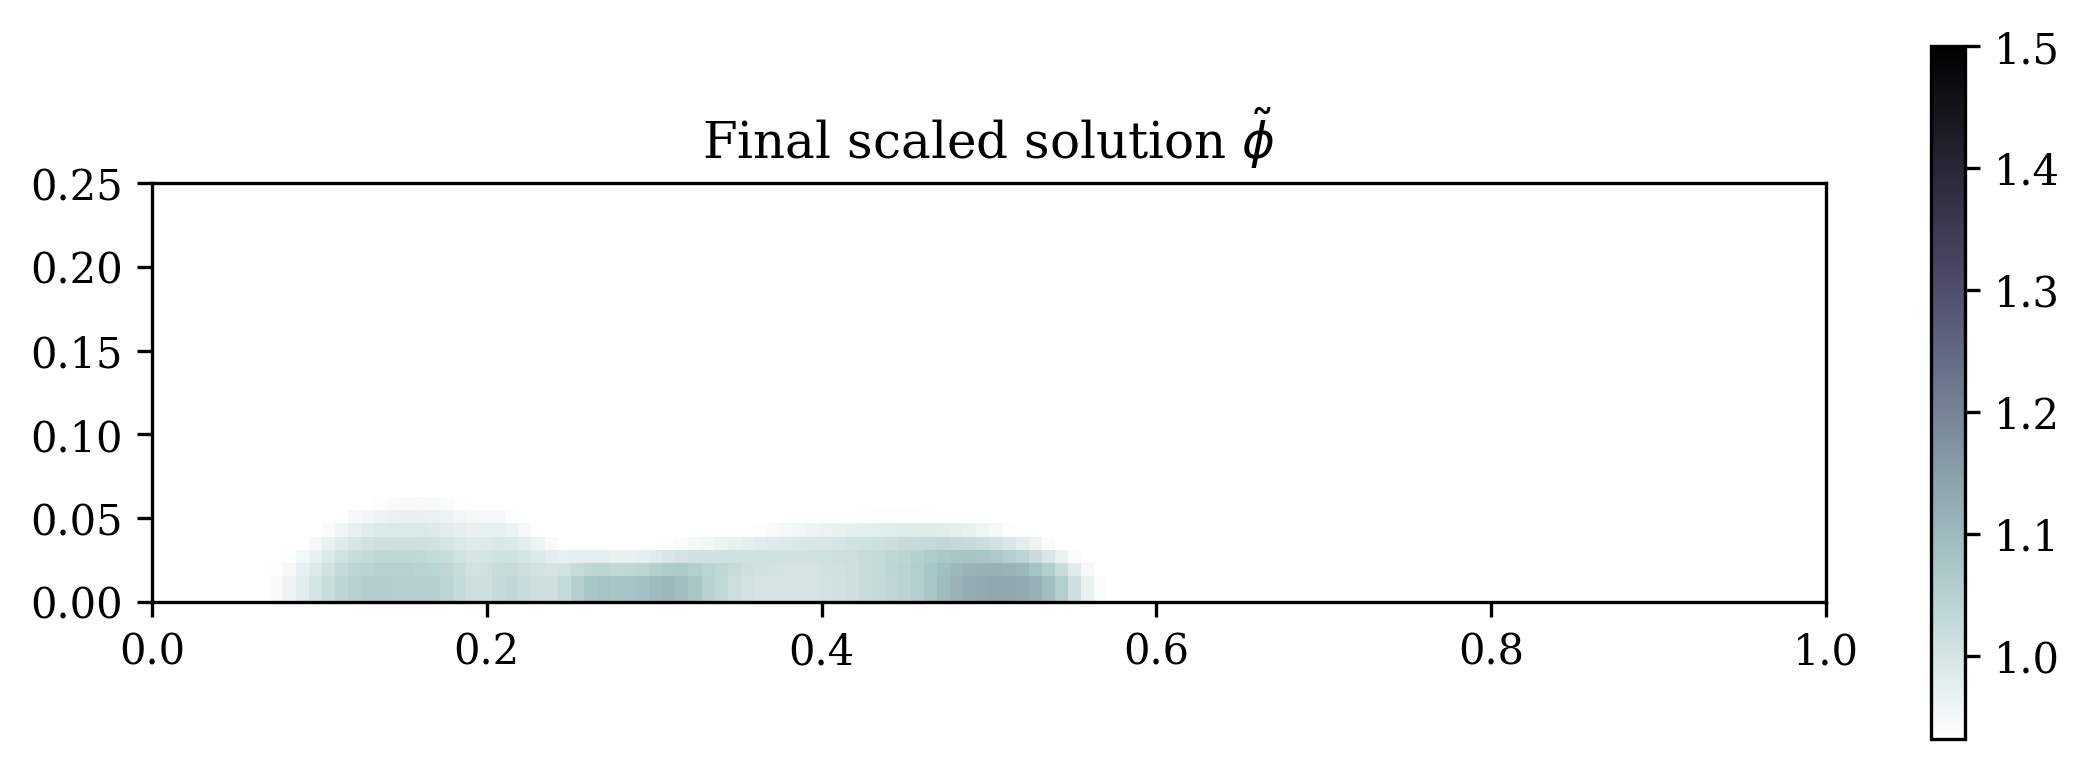

In [28]:
plt.imshow(phi_til,
            origin="lower",
            cmap=lc3,
            vmin=min_train,
            vmax=max_train,
            extent=(0, 1, 0, 0.25)
            )
plt.title(r"Final scaled solution $\tilde{\phi}$")
plt.colorbar()

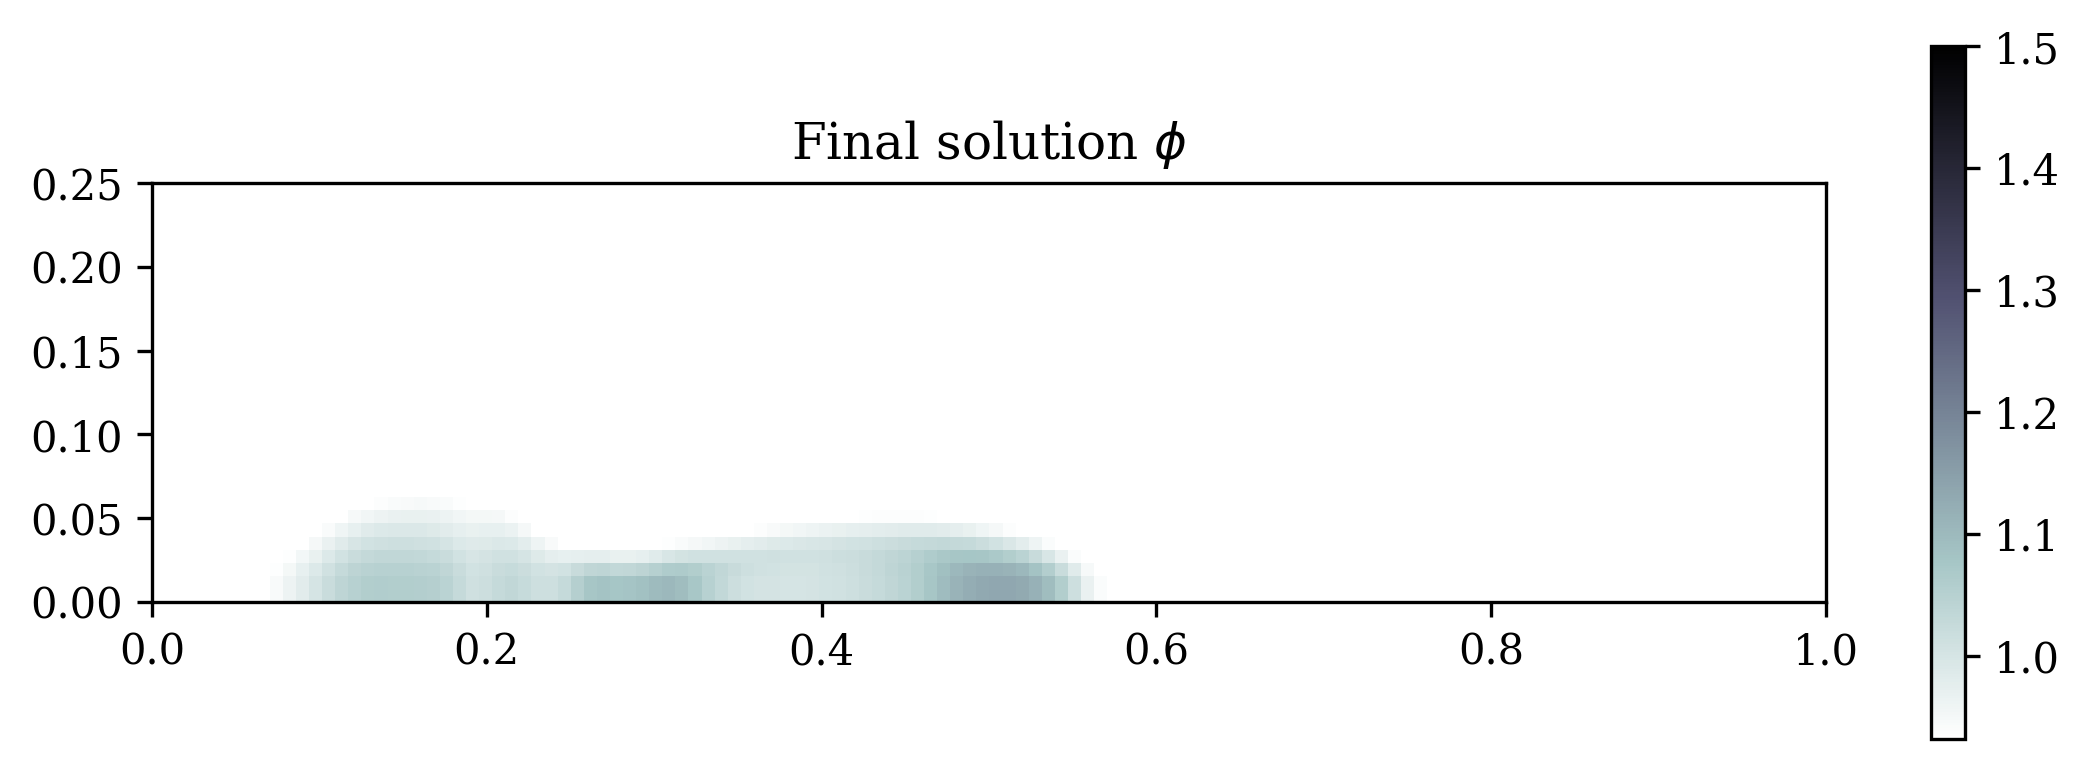

In [29]:
plt.imshow(phi_til / f_decay,
            origin="lower",
            cmap=lc3,
            vmin=min_train,
            vmax=max_train,
            extent=(0, 1, 0, 0.25)
            )
plt.title(r"Final solution $\phi$")
plt.colorbar()